[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mfurio93/Used-Cars-Dataset/blob/main/02%20-%20Project%202.ipynb)

# Libraries

In [1]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import matplotlib
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sb
from tabulate import tabulate 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.utils import shuffle
from sklearn.cluster import AgglomerativeClustering

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (25, 12)
plt.style.use('ggplot')

# File importation and cleaning

We now import the .csv files.

They contain data related to the male and female labor force along with country GDP (Gross Domestic Product).

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1h7BE5hPVF_dCZiqelgPMdpuyujbZblbg'
download = drive.CreateFile({'id':file_id})
download.GetContentFile('Male.csv')

file_id = '16uNZicJTSPGNSqrVgD7I6nkN-kdV3npf'
download = drive.CreateFile({'id':file_id})
download.GetContentFile('Female.csv')

file_id = '1USrX33Uk0rCEOZrKREf-rTFUrOZh0mao'
download = drive.CreateFile({'id':file_id})
download.GetContentFile('GDP.csv')

Importing and cleaning the male and female labor force dataset.

There is some missing/faulty data and unnecessary columns to our analysis that we will now clean.

To avoid redundancy, we will also be working with less yearly data. We chose the years 1990, 2010, and 2018 for the analysis.

In [3]:
male = pd.read_csv('Male.csv', delimiter=',', on_bad_lines='skip', header=1) 
unnamed_cols_male = male.columns.str.contains('Unnamed')
male_clean = male.drop(male[male.columns[unnamed_cols_male]], axis=1)
male_clean = male_clean.dropna()
male_clean.drop([192,193,194,195,196,198,199,200,201,202,203,204,205,206,207],
                axis=0, inplace=True)
male_clean.replace("..", np.nan, inplace=True)
male_clean.replace(" ", np.NaN, inplace=True)
male_clean.drop(["1995","2000","2005","2011","2012","2013","2014",
                 "2015","2016","2017"], axis=1, inplace=True)

female = pd.read_csv('Female.csv', delimiter=',', on_bad_lines='skip', header=1) 
unnamed_cols_female = female.columns.str.contains('Unnamed')
female_clean = female.drop(female[female.columns[unnamed_cols_female]], axis=1)
female_clean = female_clean.dropna()
female_clean.drop([192,193,194,195,196,198,199,200,201,202,203,204,205,206,207],
                  axis=0, inplace=True)
female_clean.replace("..", np.NaN, inplace=True)
female_clean.replace(" ", np.NaN, inplace=True)
female_clean.drop(["1995","2000","2005","2011","2012","2013","2014",
                   "2015","2016","2017"], axis=1, inplace=True)

We also clean the CSV with the GDP data. It's a little simpler this time.

In [4]:
GDP = pd.read_csv('GDP.csv', delimiter=',', on_bad_lines='skip', header=0,
                  names=["Pais","Continente","Pib"]) 
unnamed_cols_GDP = GDP.columns.str.contains('Unnamed')
GDP_clean = GDP.drop(GDP[GDP.columns[unnamed_cols_GDP]], axis=1)
GDP_clean = GDP_clean.dropna()

We'll also convert yearly and HDI data on the labor force dataframes to float for ease of work. Additionally, we fill the missing data with the mean.

In [5]:
female_clean["1990"] = pd.to_numeric(female_clean["1990"])
female_clean["2010"] = pd.to_numeric(female_clean["2010"])
female_clean["2018"] = pd.to_numeric(female_clean["2018"])
female_clean["HDI Rank (2018)"] = pd.to_numeric(female_clean["HDI Rank (2018)"])
male_clean["1990"] = pd.to_numeric(male_clean["1990"])
male_clean["2010"] = pd.to_numeric(male_clean["2010"])
male_clean["2018"] = pd.to_numeric(male_clean["2018"])
male_clean["HDI Rank (2018)"] = pd.to_numeric(male_clean["HDI Rank (2018)"])
column_means_female = female_clean.mean()
female_clean = female_clean.fillna(column_means_female)
column_means_male = male_clean.mean()
male_clean = male_clean.fillna(column_means_male)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()


# Joining Dataframes

We join the dataframes together, changing the name of the columns for clarity along with dropping duplicates, and afterwards we make sure that all numeric data is stored as a float.

In [6]:
female_clean.rename(columns = {'1990':'1990 F', '2010':'2010 F', '2018':'2018 F'}, inplace = True)
male_clean.rename(columns = {'1990':'1990 M', '2010':'2010 M', '2018':'2018 M'}, inplace = True)
dataframe = pd.concat([GDP_clean,male_clean,female_clean], axis=1, join='inner').sort_index()
dataframe = dataframe.T.drop_duplicates().T
dataframe.drop(["Country"], axis=1, inplace=True)
dataframe["1990 F"] = pd.to_numeric(dataframe["1990 F"])
dataframe["1990 M"] = pd.to_numeric(dataframe["1990 M"])
dataframe["2010 F"] = pd.to_numeric(dataframe["2010 F"])
dataframe["2010 M"] = pd.to_numeric(dataframe["2010 M"])
dataframe["2018 F"] = pd.to_numeric(dataframe["2018 F"])
dataframe["2018 M"] = pd.to_numeric(dataframe["2018 M"])
dataframe["Pib"] = pd.to_numeric(dataframe["Pib"])
dataframe["HDI Rank (2018)"] = pd.to_numeric(dataframe["HDI Rank (2018)"])

# Outliers

We pull out outliers (GDP-wise) that make the processing of our data difficult.

Additionally, we shuffle the rows to avoid any bias during processing. We also get rid of the country and continent columns in this step.

In [7]:
z = np.abs(stats.zscore(dataframe["Pib"]))
data = dataframe.copy()
data["Z_CT"] = z
data[data["Z_CT"] > 2]
data = data[data["Z_CT"] <= 2]
data = shuffle(data)
dataframe_clean = data.drop(["Pais","Continente","Z_CT"], axis=1)

# Correlation Matrix

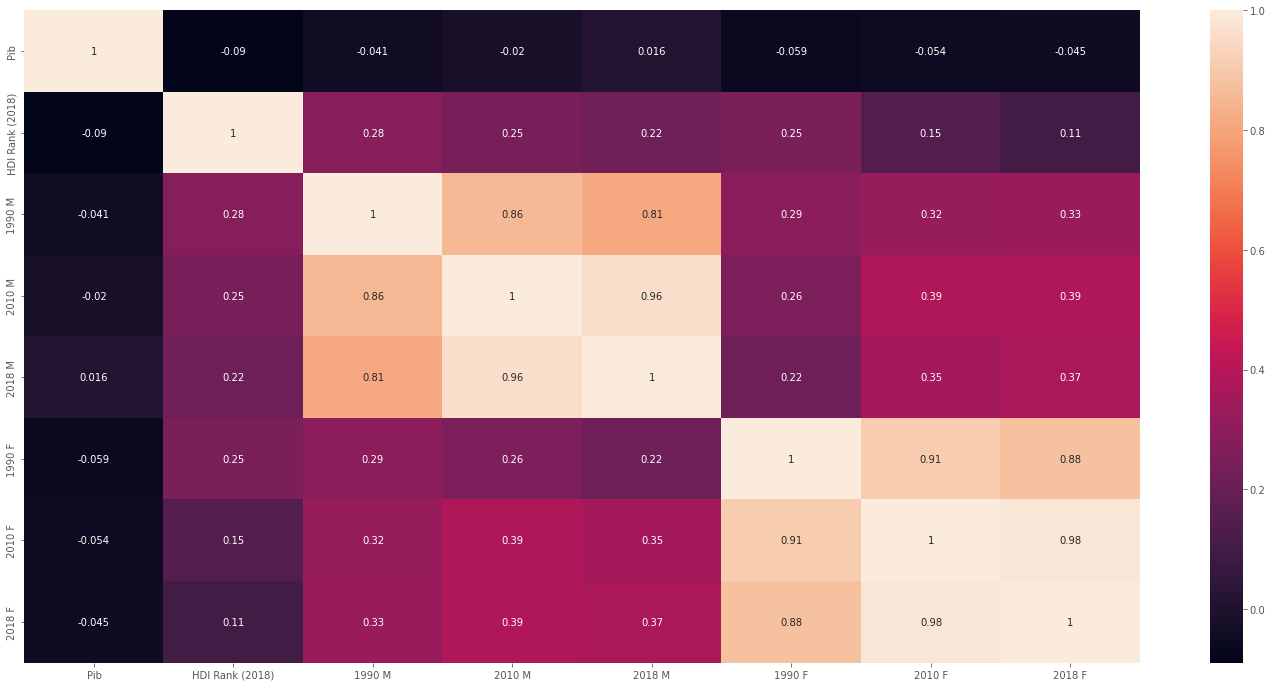

In [8]:
corrMatrix = dataframe_clean.corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()

# Pair Plot Analysis

The goal of this analysis is to find three interesting columns to create an adequate analysis, so that we can separate our data in clusters.

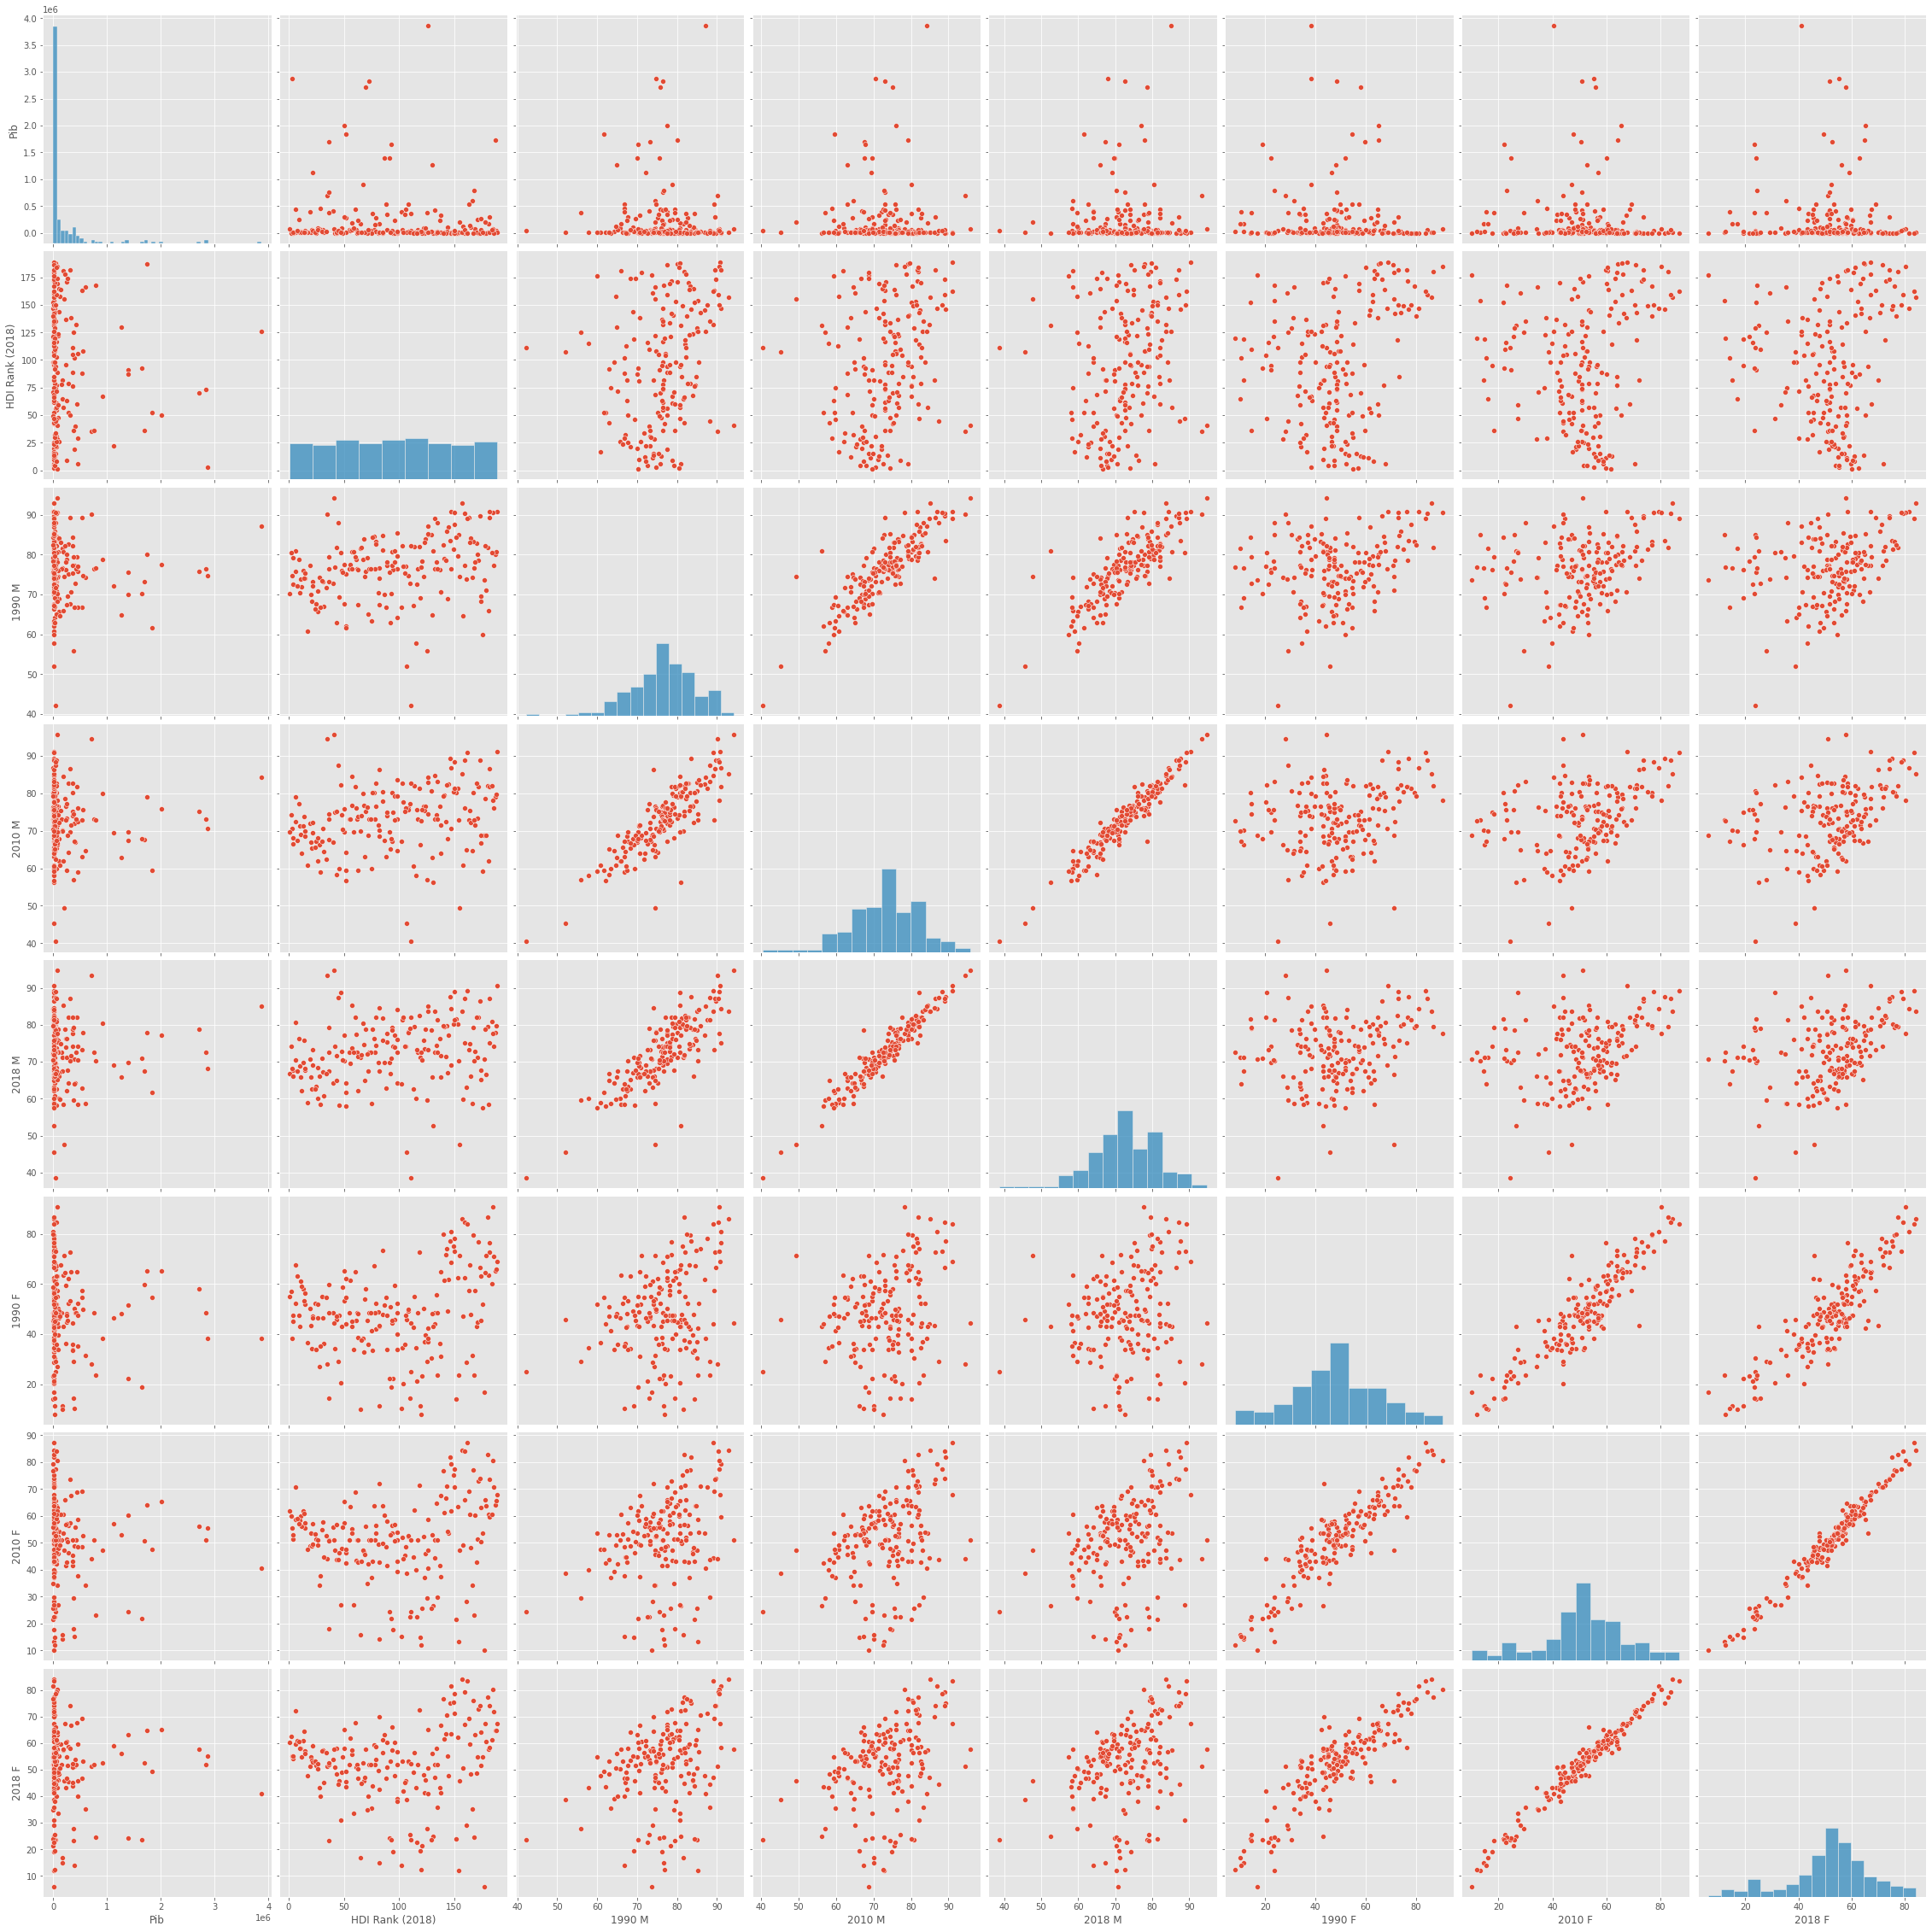

In [9]:
sb.pairplot(dataframe_clean.dropna(), height=4, vars=dataframe_clean.columns, kind='scatter')
plt.show()

Here, we'll choose GDP, HDI, and 2018 F.

# Elbow Curve

Based on the chosen columns, the elbow curve helps us identify how many clusters we should be grouping the data in.

In [10]:
dataframe_3D = np.array(dataframe_clean[['Pib', 'HDI Rank (2018)', '2018 F']])
dataframe_3D_labels = np.array(dataframe_clean)
print(dataframe_3D.shape)

(186, 3)


Values:  [57589328271672.23, 12968092968675.701, 6430153906000.236, 2719008776460.9297, 1881698705616.3528, 1108061579178.3208, 662722807407.1483, 418548731094.1666, 334013442760.3025, 259704044245.9898]


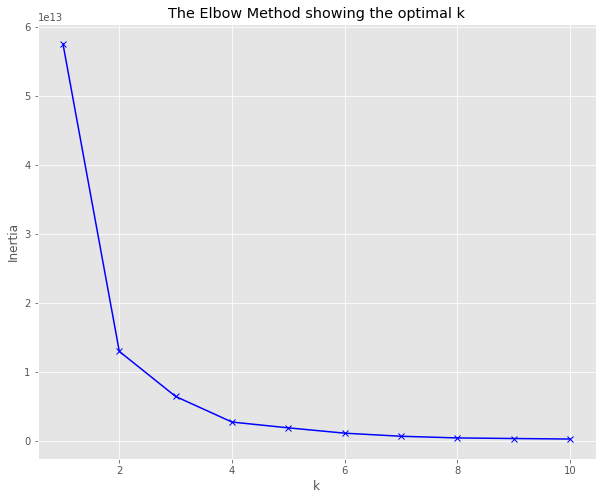

In [12]:
def elbow_curve(data, maxClusters = 15):

  # Value range of the paramater we wish to optimize (amount of clusters)
  maxClusters = range(1, maxClusters + 1)
  inertias = []

  # We run the model for the range of clusters and keep the obtained inertia for each value
  for k in maxClusters:
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(data)
    inertias.append(kmeanModel.inertia_)

  # Graphing the results
  print("Values: ",inertias)
  plt.figure(figsize=(10, 8))
  plt.plot(maxClusters, inertias, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Inertia')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()

elbow_curve(dataframe_3D,10)

The curve here clearly flattens at k = 4, so that's the value that this model gives us.

# Gap Statistic

In [13]:
# nrefs is the amount of reference data we'll compare against
def optimalK(data, nrefs=3, maxClusters=15):

    gaps = np.zeros((len(range(1, maxClusters+1)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters+1)):

        # Save the scatter results of each generated simulation
        refDisps = np.zeros(nrefs)

        # Generate random samples indicated by nrefs and run KMeans on each loop obtaining scatter
        # results for each generated group
        for i in range(nrefs):
            
            # Create a new random reference group
            # A seed can be used to obtain reproductability
            np.random.seed(0)
            randomReference = np.random.random_sample(size=data.shape)
            
            # Adjust the model to the reference group
            km = KMeans(k)
            km.fit(randomReference)
            # Save the obtained scatter
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Adjust the model to the original data and keep the inertia
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Get the gap statistic for k clusters using the scatter average of the simulated
        # data and the scatter of the original data
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Save the gap statistic obtained in this loop
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    # Select the first maximum of the obtained statistics and return its respective cluster #
    for i in range(0, len(gaps)-1):
      if gaps[i+1] <= gaps[i]:
        return (i+1, resultsdf)
    return (len(gaps), resultsdf)

In [15]:
k, gapdf = optimalK(dataframe_3D, nrefs=5, maxClusters=10)
print('The optimal cluster amount is:', k)

The optima cluster amount is: 10


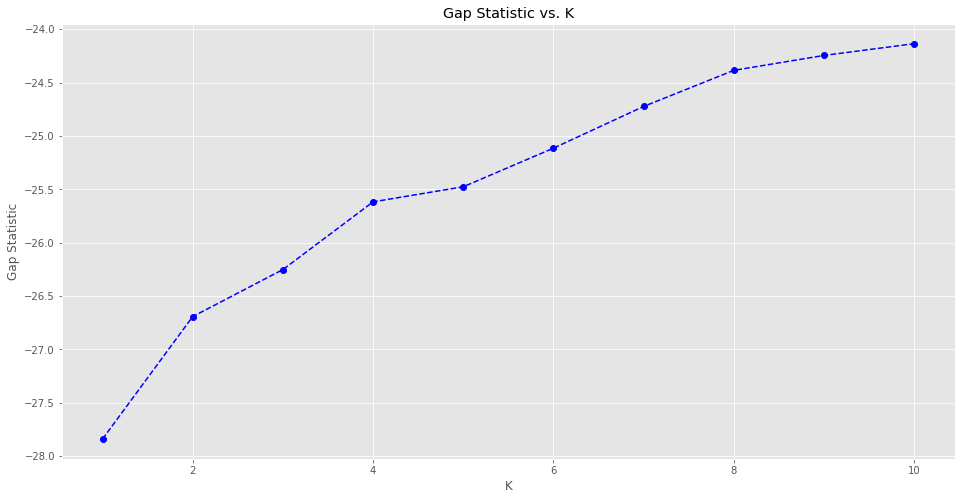

In [16]:
plt.figure(figsize=(16,8))
plt.plot(gapdf['clusterCount'], gapdf['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Gap Statistic');
plt.title('Gap Statistic vs. K');

The result of 10 is a tad high so we'll look at another method to confirm what's going on.

# Silhouette Analysis

This method is used to determine cluster numbers as well.

For n_clusters = 2 The average silhouette_score is : 0.8828960977277133
For n_clusters = 3 The average silhouette_score is : 0.8533707454658408
For n_clusters = 4 The average silhouette_score is : 0.7907346595189941
For n_clusters = 5 The average silhouette_score is : 0.790074953246439
For n_clusters = 6 The average silhouette_score is : 0.7886257069915107


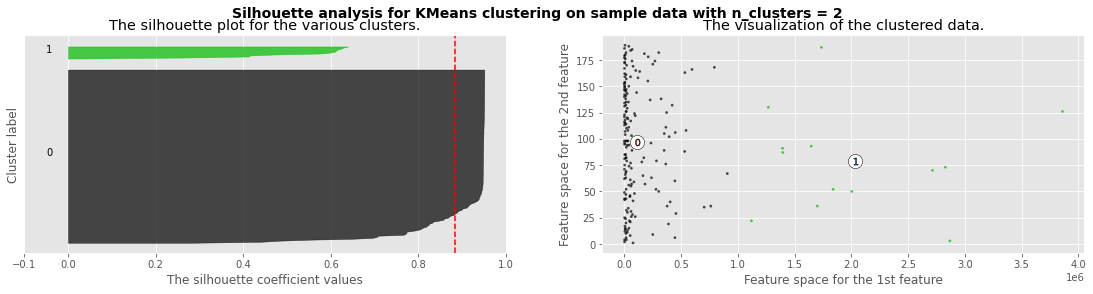

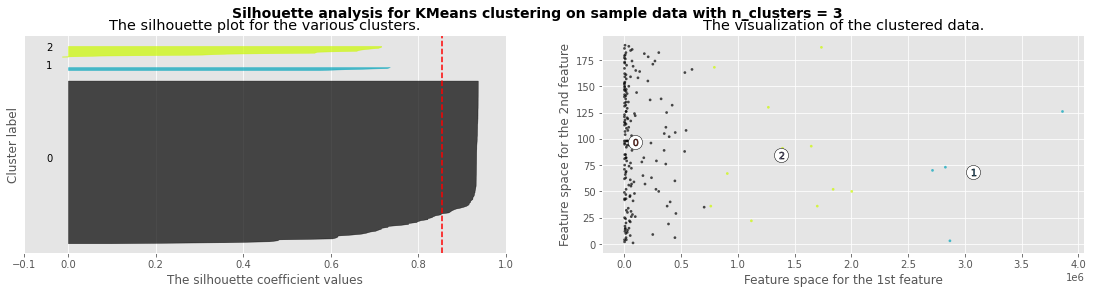

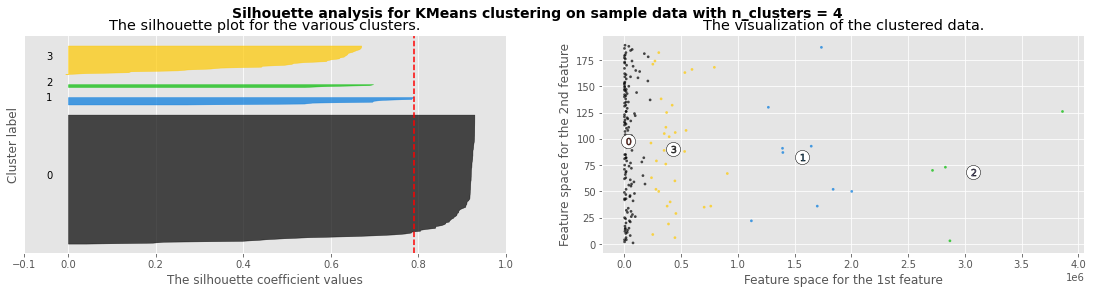

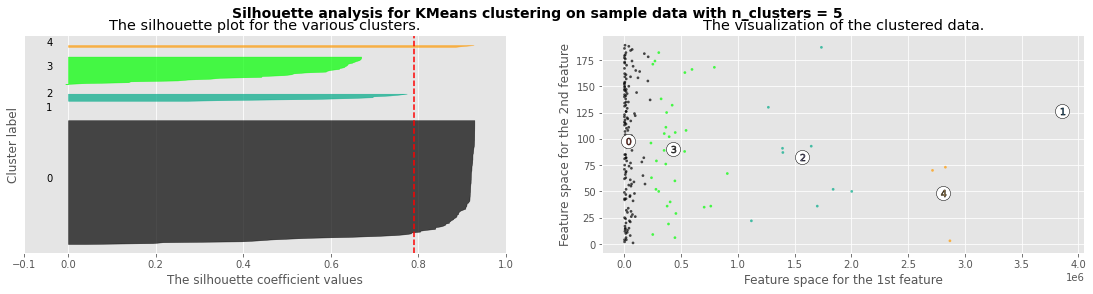

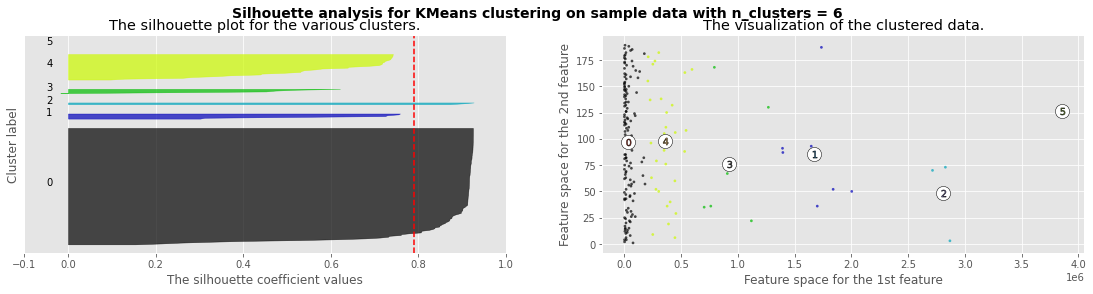

In [17]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

colors_k_means = ['cyan','purple','orange']
range_n_clusters = [2, 3, 4, 5, 6]
X = dataframe_3D

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(19, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Here, the silhouette score flattens at k = 4, so this confirms the result from the elbow curve.

# Dendrogram

In [20]:
import scipy.cluster.hierarchy as sch 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

%matplotlib inline

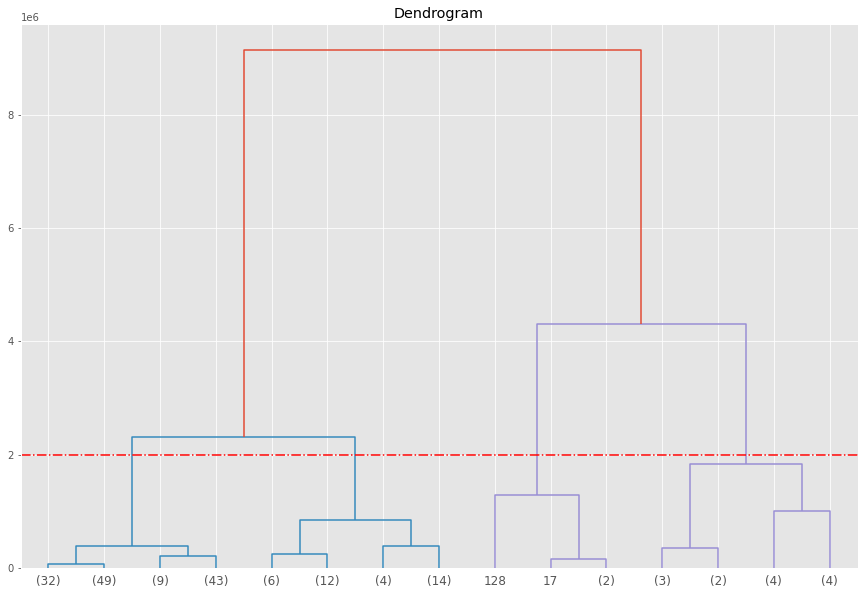

In [21]:
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(15, 10))  
pyplot.title("Dendrogram") 
dend = shc.dendrogram(shc.linkage(dataframe_clean, method='ward'),truncate_mode='level',p=3)
plt.axhline(y=2000000, color='r', linestyle='-.')
plt.show()

To choose the height, we took into account the elbow curve and silhouette analysis, giving us a
division in four groups.

# Hierarchical Clustering

In [22]:
def minmax_norm(df):
    return (df - df.min()) / ( df.max() - df.min())
dataframe_clean_copy = dataframe_clean.copy()
dataframe_clean_copy = minmax_norm(dataframe_clean_copy)
dataframe_clean_copy.head()

,Pib,HDI Rank (2018),1990 M,2010 M,2018 M,1990 F,2010 F,2018 F
189,0.014989,0.287234,0.658686,0.589761,0.605565,0.488419,0.530642,0.585827
31,0.449713,0.989362,0.726923,0.698556,0.700535,0.689238,0.701299,0.751918
98,0.000783,0.909574,0.698077,0.747292,0.773619,0.828295,0.818182,0.855499
27,0.000768,0.771277,0.794231,0.882671,0.873440,0.834341,0.931169,0.884910
137,0.009867,0.585106,0.000000,0.000000,0.000000,0.203144,0.184416,0.226343


# Clusters = 4

In [23]:
# Create the model with euclidean metric minimizing variability between data
model=AgglomerativeClustering(n_clusters=4, linkage='ward')

#Apply the model
data_fit_4=model.fit(dataframe_clean_copy)
lab_4c=data_fit_4.labels_
dataframe_clean['Labels_4Clusters']=lab_4c

# Characterization

Group 0:
           Pib  HDI Rank (2018)  1990 M  2010 M  2018 M  1990 F  2010 F  \
31   1736425.0            187.0    80.0    79.1    77.9    65.1    64.1   
98      3070.0            172.0    78.5    81.8    82.0    76.6    73.1   
27      3012.0            146.0    83.5    89.3    87.6    77.1    81.8   
30     39007.0            188.0    80.8    79.7    79.8    65.7    65.7   
111    14048.0            145.0    87.0    82.4    77.3    61.8    53.6   

     2018 F  Labels_4Clusters  
31     64.8                 0  
98     72.9                 0  
27     75.2                 0  
30     64.7                 0  
111    47.7                 0  
(44, 9)


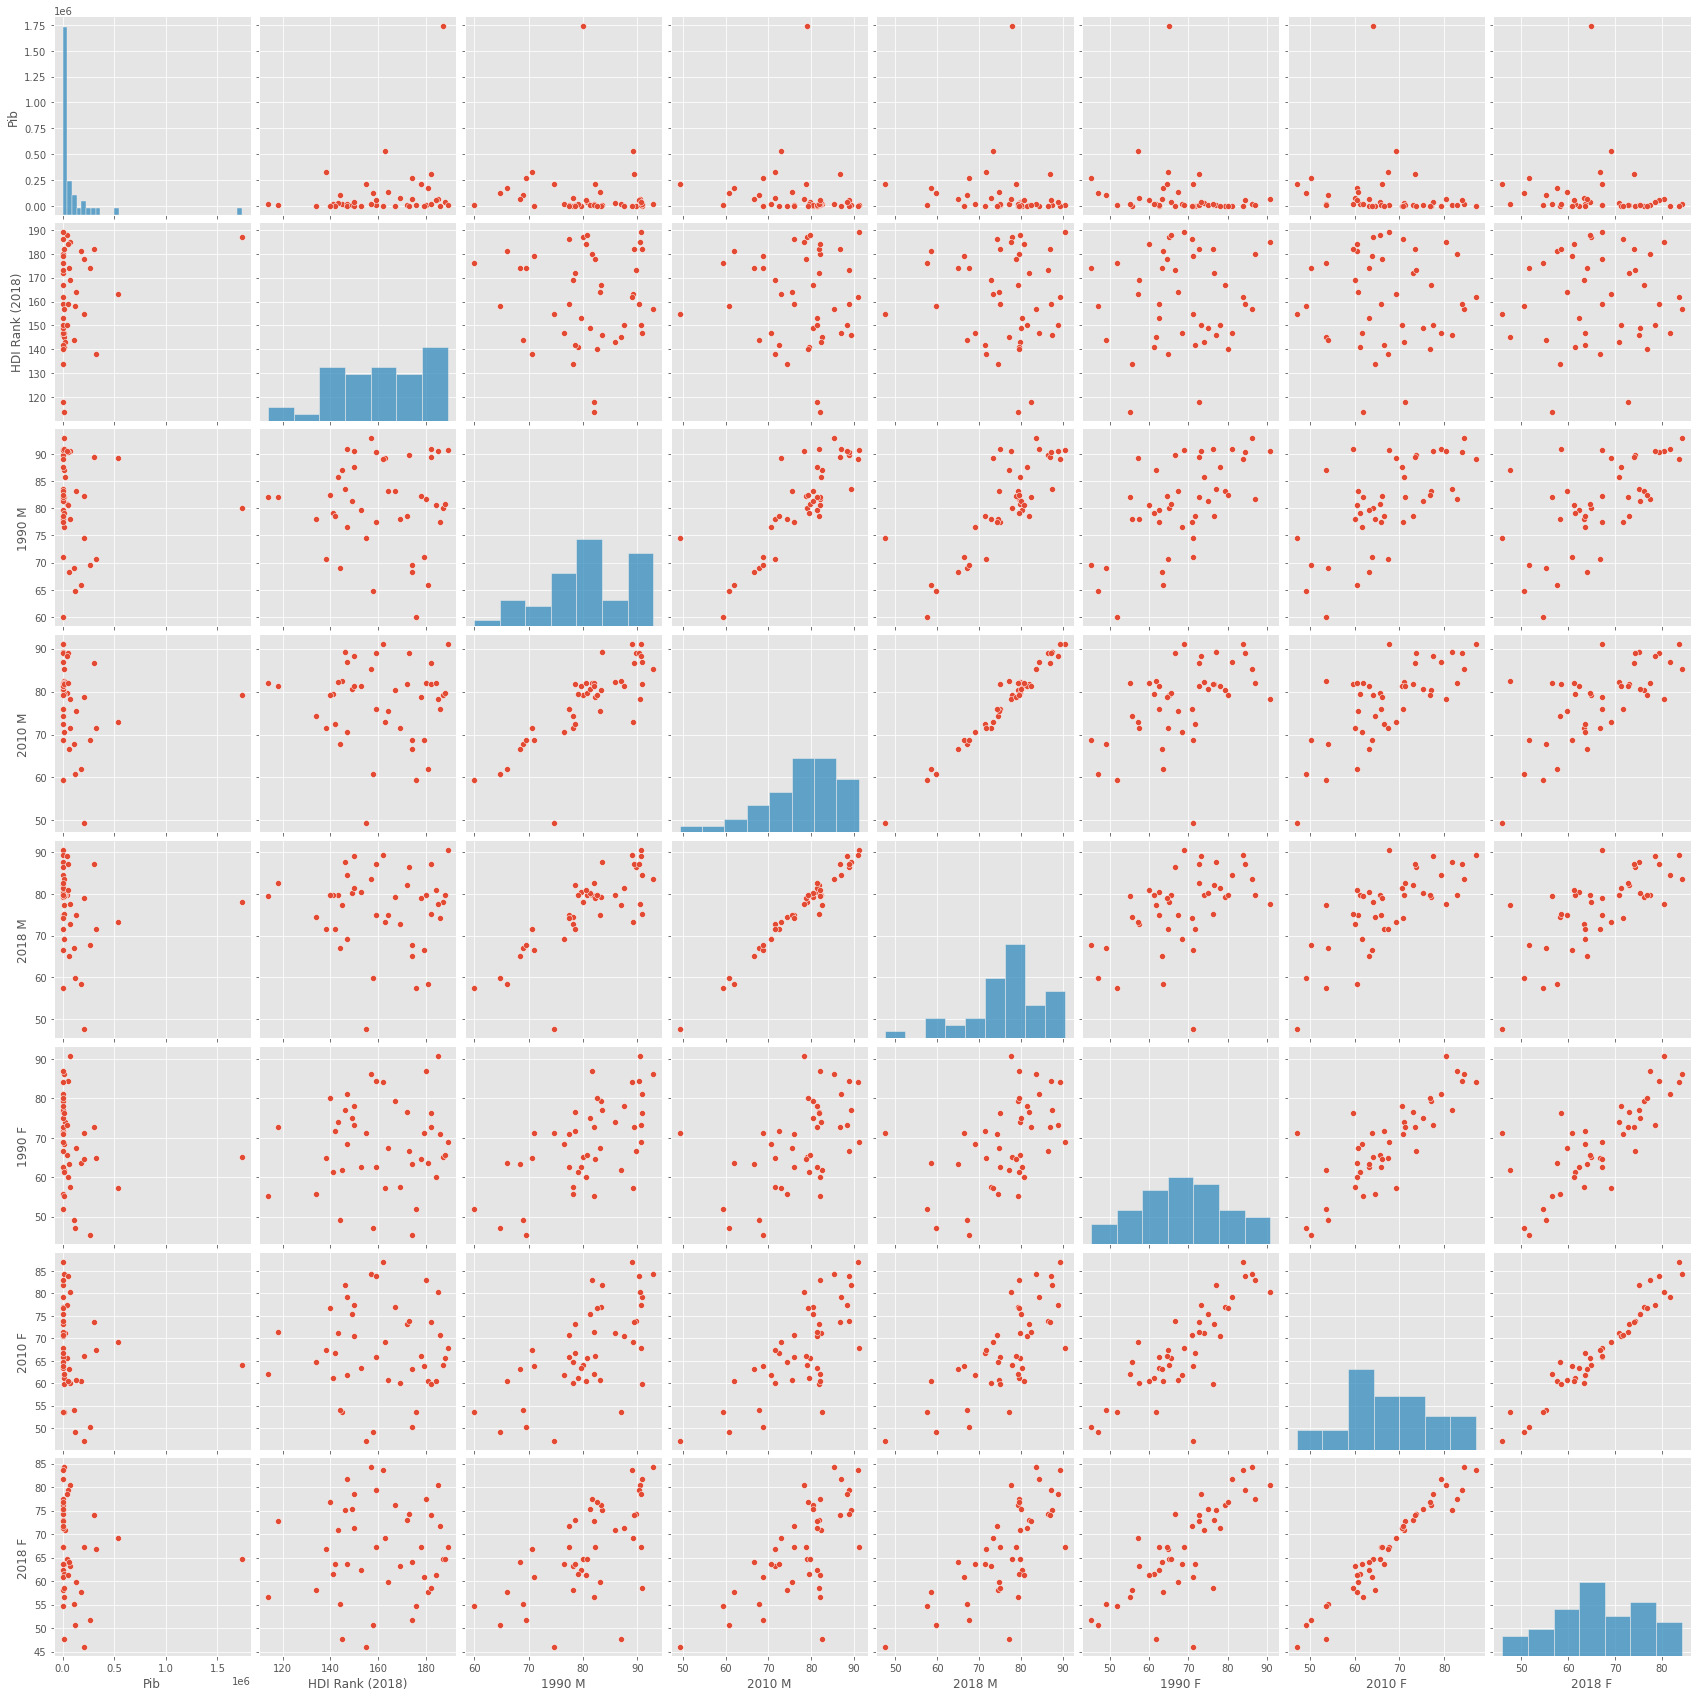

In [24]:
print("Group 0:")
is_G=dataframe_clean.loc[:, 'Labels_4Clusters']==0
C3_G=dataframe_clean[is_G]
print(C3_G.head())
print(C3_G.shape)

sb.pairplot(C3_G,
            height=3, 
            vars=['Pib', 'HDI Rank (2018)', '1990 M', '2010 M','2018 M','1990 F', '2010 F','2018 F']
            , kind='scatter')
plt.show()

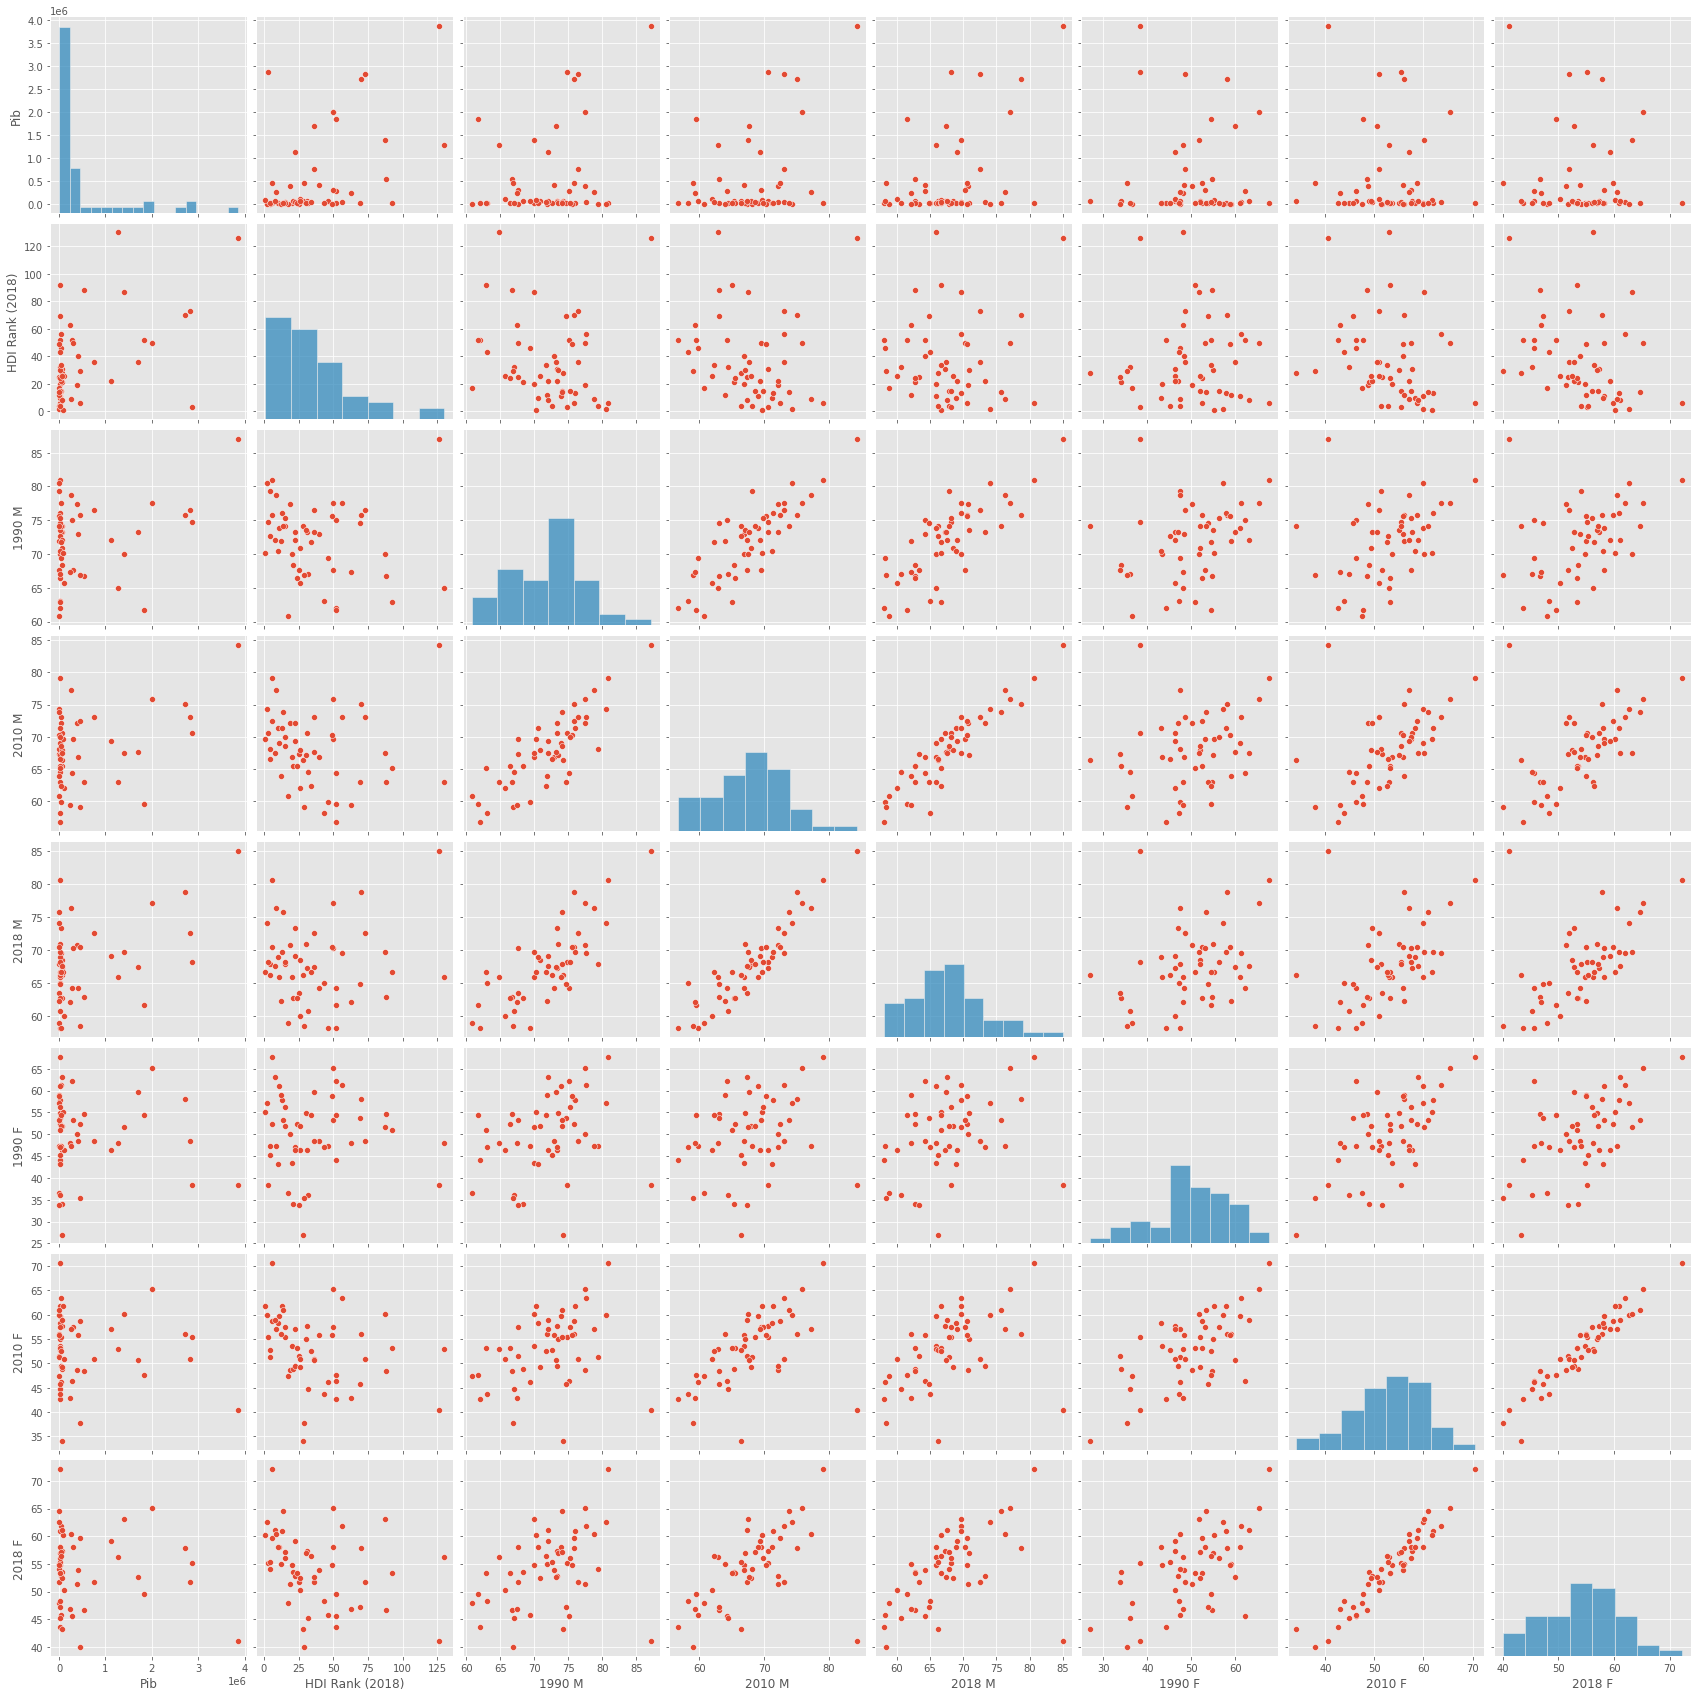

In [25]:
print("Group 1:")
is_G=dataframe_clean.loc[:, 'Labels_4Clusters']==1
C3_G=dataframe_clean[is_G]
print(C3_G.head())
print(C3_G.shape)

sb.pairplot(C3_G,
            height=3, 
            vars=['Pib', 'HDI Rank (2018)', '1990 M', '2010 M','2018 M','1990 F', '2010 F','2018 F']
            , kind='scatter')
plt.show()

Group 2:
          Pib  HDI Rank (2018)  1990 M  2010 M  2018 M  1990 F  2010 F  \
137   38145.0       111.000000    42.2    40.4    38.6    24.9    24.3   
140  595858.0       166.000000    74.4    64.7    58.6    31.4    34.3   
2    171091.0        82.000000    76.6    70.1    67.4    11.4    14.4   
147    2122.0        94.772487    76.2    74.9    74.3    22.3    17.6   
157  372062.0       125.000000    55.8    57.0    59.7    29.0    29.5   

     2018 F  Labels_4Clusters  
137    23.7                 2  
140    35.2                 2  
2      14.9                 2  
147    19.1                 2  
157    27.8                 2  
(32, 9)


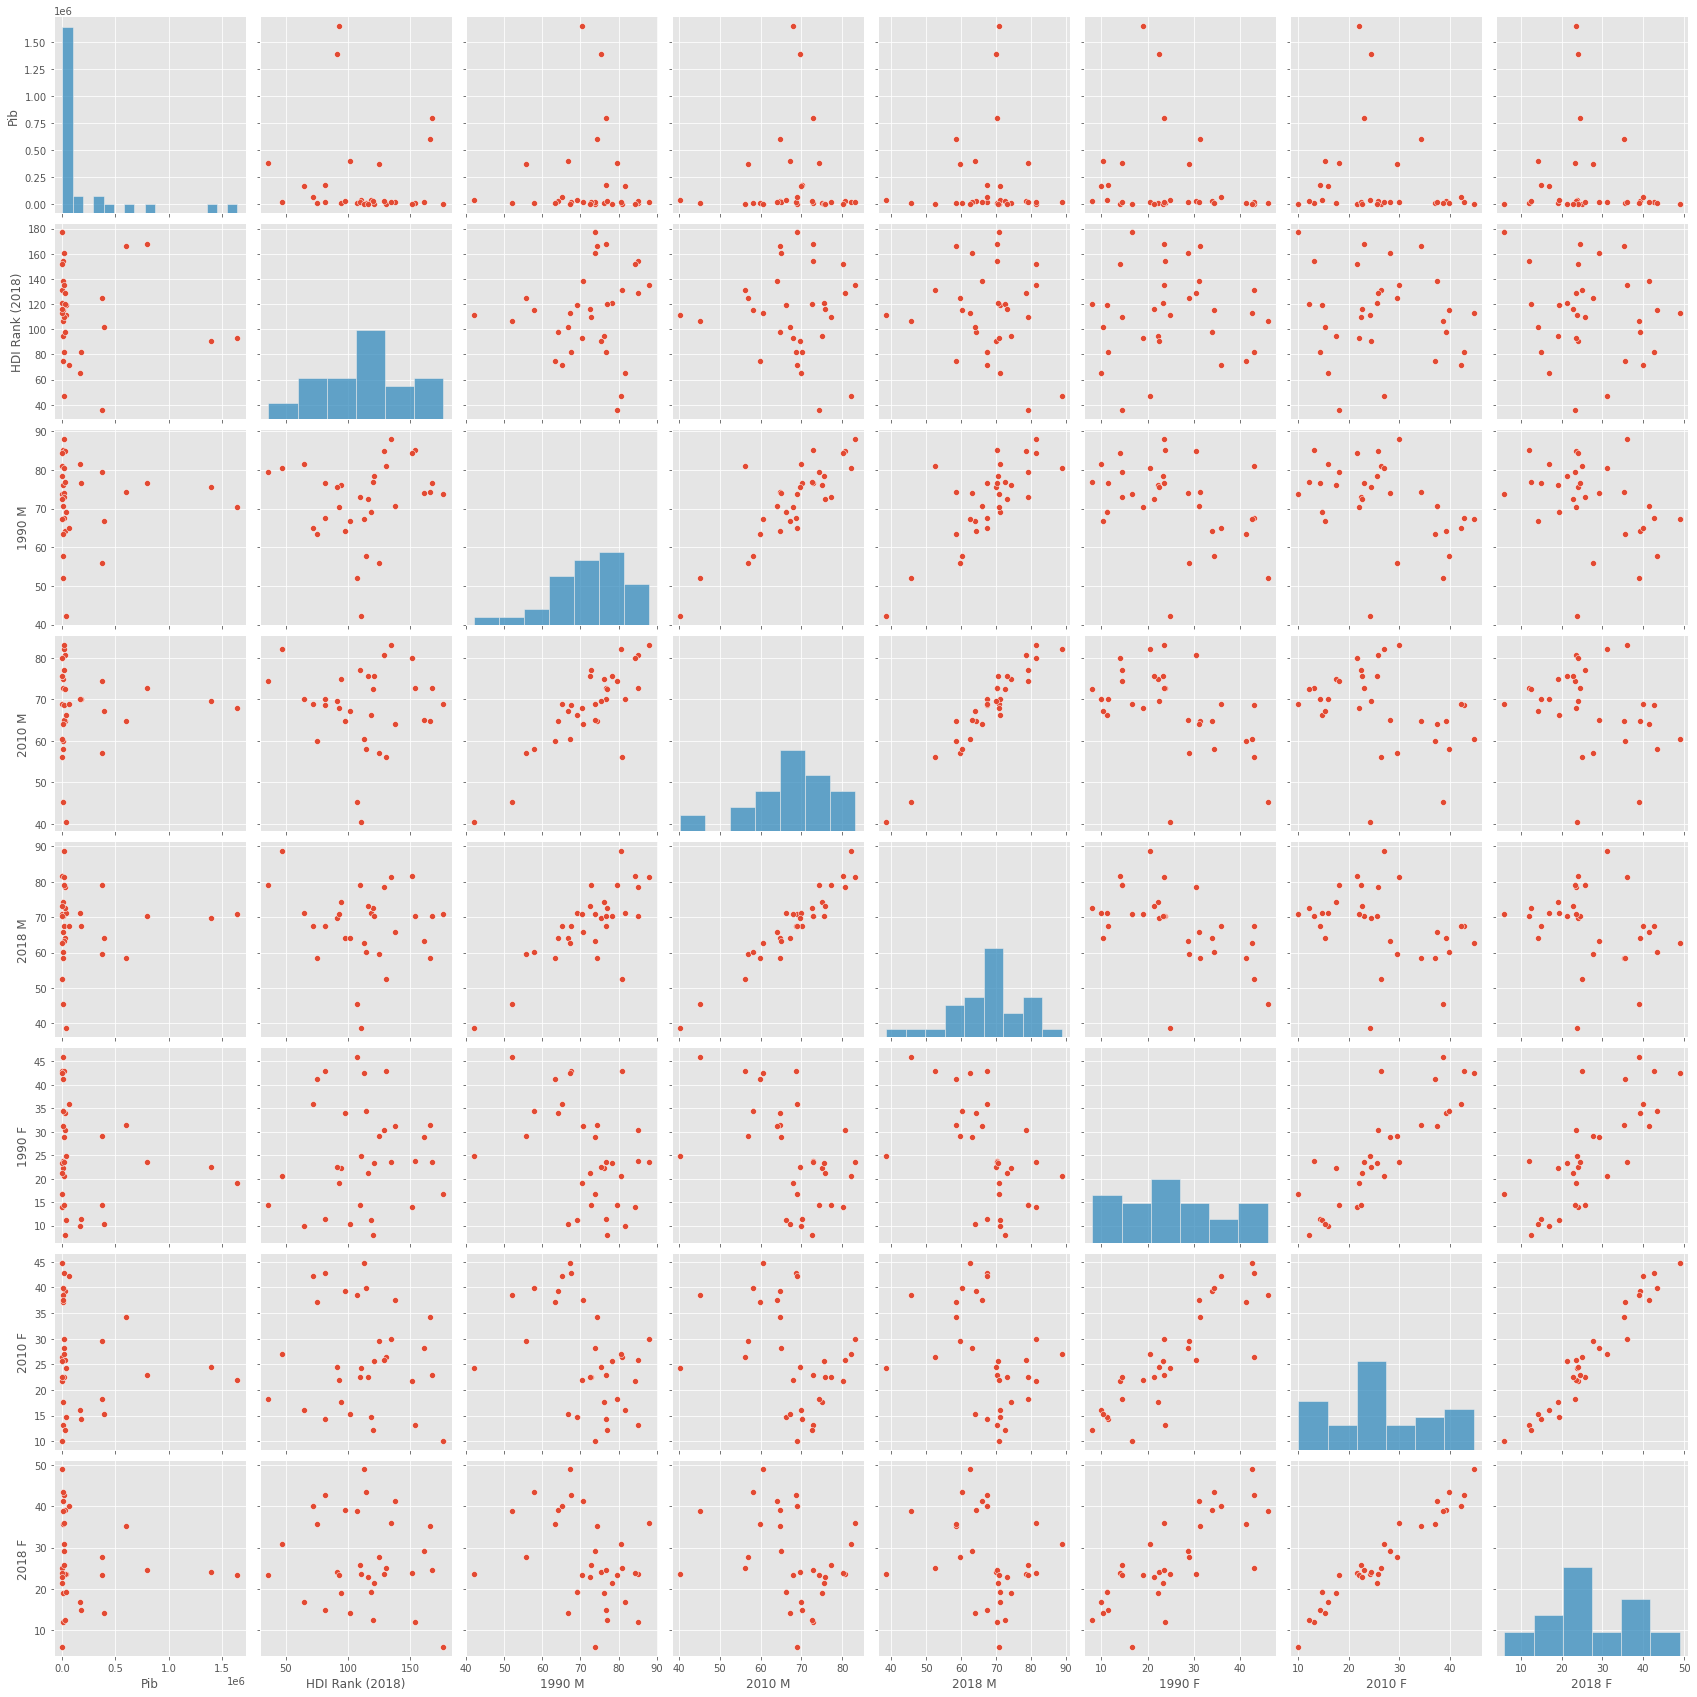

In [26]:
print("Group 2:")
is_G=dataframe_clean.loc[:, 'Labels_4Clusters']==2
C3_G=dataframe_clean[is_G]
print(C3_G.head())
print(C3_G.shape)

sb.pairplot(C3_G,
            height=3, 
            vars=['Pib', 'HDI Rank (2018)', '1990 M', '2010 M','2018 M','1990 F', '2010 F','2018 F']
            , kind='scatter')
plt.show()

Group 3:
          Pib  HDI Rank (2018)     1990 M     2010 M     2018 M     1990 F  \
189   57921.0             55.0  76.451667  73.072778  72.572222  48.492222   
38    12267.0             68.0  83.900000  76.700000  74.600000  32.900000   
159   54174.0             77.0  84.600000  80.100000  76.200000  67.200000   
88    95503.0            122.0  74.500000  76.600000  75.800000  50.200000   
46   350104.0             89.0  77.400000  74.000000  77.600000  33.800000   

        2010 F     2018 F  Labels_4Clusters  
189  50.959444  51.811667                 3  
38   46.600000  45.700000                 3  
159  63.900000  59.500000                 3  
88   52.200000  48.000000                 3  
46   41.600000  50.900000                 3  
(57, 9)


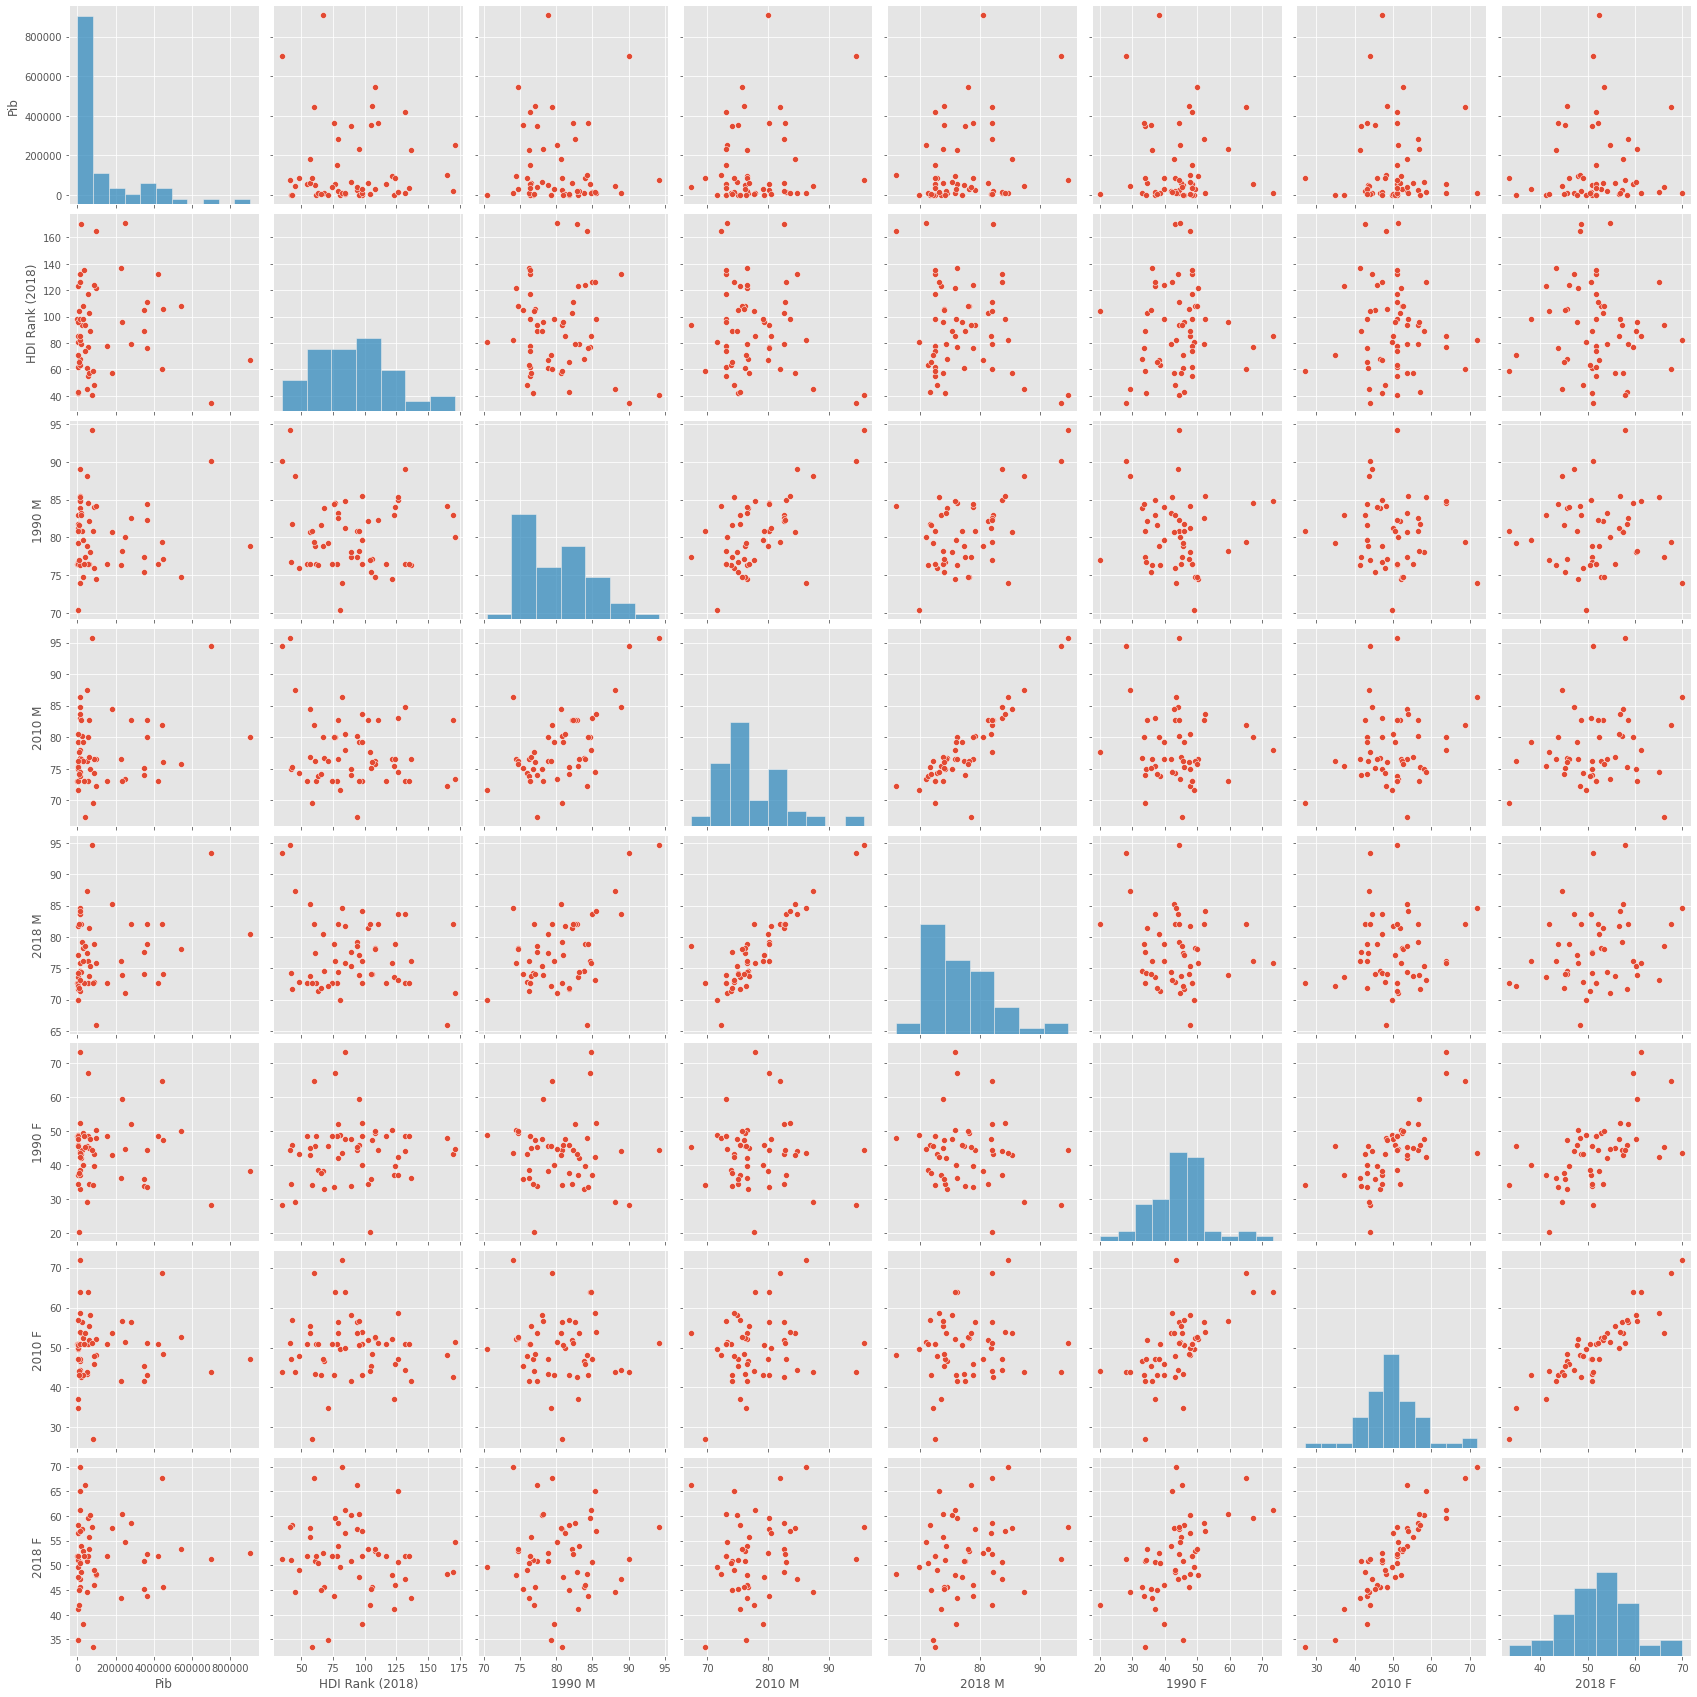

In [27]:
print("Group 3:")
is_G=dataframe_clean.loc[:, 'Labels_4Clusters']==3
C3_G=dataframe_clean[is_G]
print(C3_G.head())
print(C3_G.shape)

sb.pairplot(C3_G,
            height=3, 
            vars=['Pib', 'HDI Rank (2018)', '1990 M', '2010 M','2018 M','1990 F', '2010 F','2018 F']
            , kind='scatter')
plt.show()

In [33]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [39]:
group0 = dataframe_clean[dataframe_clean['Labels_4Clusters']==0].drop('Labels_4Clusters',axis=1)
group0.describe()

,Pib,HDI Rank (2018),1990 M,2010 M,2018 M,1990 F,2010 F,2018 F
count,44,44,44,44,44,44,44,44
mean,106476,161,81,78,76,69,68,67
std,275240,19,8,9,9,11,10,10
min,194,114,60,49,48,45,47,46
25%,2853,147,77,72,72,62,61,61
50%,14219,160,82,80,79,69,66,67
75%,84391,178,88,82,82,76,74,74
max,1736425,189,93,91,90,91,87,84


In [35]:
group1 = dataframe_clean[dataframe_clean['Labels_4Clusters']==1].drop('Labels_4Clusters', axis=1)
group1.describe()

,Pib,HDI Rank (2018),1990 M,2010 M,2018 M,1990 F,2010 F,2018 F
count,53,53,53,53,53,53,53,53
mean,501611,36,72,68,68,50,53,54
std,900825,30,5,6,6,9,7,7
min,268,1,61,57,58,27,34,40
25%,14989,14,68,64,64,46,49,50
50%,51475,28,73,68,67,51,53,55
75%,445445,50,76,71,70,55,58,58
max,3861123,130,87,84,85,68,71,72


In [36]:
group2 = dataframe_clean[dataframe_clean['Labels_4Clusters']==2].drop('Labels_4Clusters', axis=1)
group2.describe()

,Pib,HDI Rank (2018),1990 M,2010 M,2018 M,1990 F,2010 F,2018 F
count,32,32,32,32,32,32,32,32
mean,194340,113,72,68,68,25,26,27
std,398800,34,10,10,10,11,10,11
min,118,36,42,40,39,8,10,6
25%,3723,92,67,65,63,16,18,21
50%,16732,114,74,69,70,24,25,24
75%,165374,132,79,75,73,32,35,36
max,1646739,177,88,83,89,46,45,49


In [37]:
group3 = dataframe_clean[dataframe_clean['Labels_4Clusters']==3].drop('Labels_4Clusters', axis=1)
group3.describe()

,Pib,HDI Rank (2018),1990 M,2010 M,2018 M,1990 F,2010 F,2018 F
count,57,57,57,57,57,57,57,57
mean,133314,91,80,78,77,44,50,52
std,192636,33,5,5,6,9,8,7
min,47,35,70,67,66,20,27,34
25%,12296,66,76,74,73,38,45,48
50%,52091,89,79,76,76,45,51,52
75%,181665,108,83,80,81,48,54,57
max,907050,171,94,96,95,73,72,70
